In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [24]:
# Load the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    './Data/train',
    target_size=(227, 227),
    batch_size=8,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    './Data/test',
    target_size=(227, 227),
    batch_size=8,
    class_mode='categorical')

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [25]:
# Define the Convolutional Block
def conv_block(x, growth_rate):
    x1 = layers.BatchNormalization()(x)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(growth_rate*4, kernel_size=1, padding='same', kernel_initializer='he_normal')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(growth_rate, kernel_size=3, padding='same', kernel_initializer='he_normal')(x1)
    x = layers.Concatenate()([x, x1])
    return x

In [26]:
# Define the DenseBlock
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

In [27]:
# Define the transition block
def transition_block(x, reduction):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), kernel_size=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    return x


In [28]:
def DenseNet(blocks=[6, 12, 24, 16], growth_rate=32, classes=3):
    inputs = layers.Input(shape=(227, 227, 3))
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, block in enumerate(blocks):
        x = dense_block(x, block, growth_rate)
        if i != len(blocks) - 1:
            x = transition_block(x, 0.5)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs, x, name='densenet')
    return model

In [29]:
# Create a DenseNet model
model = DenseNet()
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 conv2d_240 (Conv2D)         (None, 114, 114, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_240 (B  (None, 114, 114, 64)         256       ['conv2d_240[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_240 (Activation  (None, 114, 114, 64)         0         ['batch_normalization_2

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/7
643/643 [==============================] - 3575s 6s/step - loss: 0.6515 - accuracy: 0.7908 - val_loss: 1.4695 - val_accuracy: 0.6553
Epoch 2/7
643/643 [==============================] - 3518s 5s/step - loss: 0.3762 - accuracy: 0.8490 - val_loss: 2.1420 - val_accuracy: 0.7065
Epoch 3/7
643/643 [==============================] - 4070s 6s/step - loss: 0.3412 - accuracy: 0.8666 - val_loss: 1.2095 - val_accuracy: 0.3960
Epoch 4/7
643/643 [==============================] - 4085s 6s/step - loss: 0.2904 - accuracy: 0.8913 - val_loss: 0.9509 - val_accuracy: 0.8393
Epoch 5/7
643/643 [==============================] - 3792s 6s/step - loss: 0.2786 - accuracy: 0.8970 - val_loss: 5.3152 - val_accuracy: 0.2989
Epoch 6/7
643/643 [==============================] - 3425s 5s/step - loss: 0.2804 - accuracy: 0.8966 - val_loss: 0.2998 - val_accuracy: 0.8851
Epoch 7/7
643/643 [==============================] - 3365s 5s/step - loss: 0.2632 - accuracy: 0.9073 - val_loss: 0.3051 - val_accuracy: 0.8890

In [32]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)


161/161 - 143s - loss: 0.3051 - accuracy: 0.8890 - 143s/epoch - 890ms/step

Test accuracy: 0.8889751434326172

Test loss: 0.30511853098869324


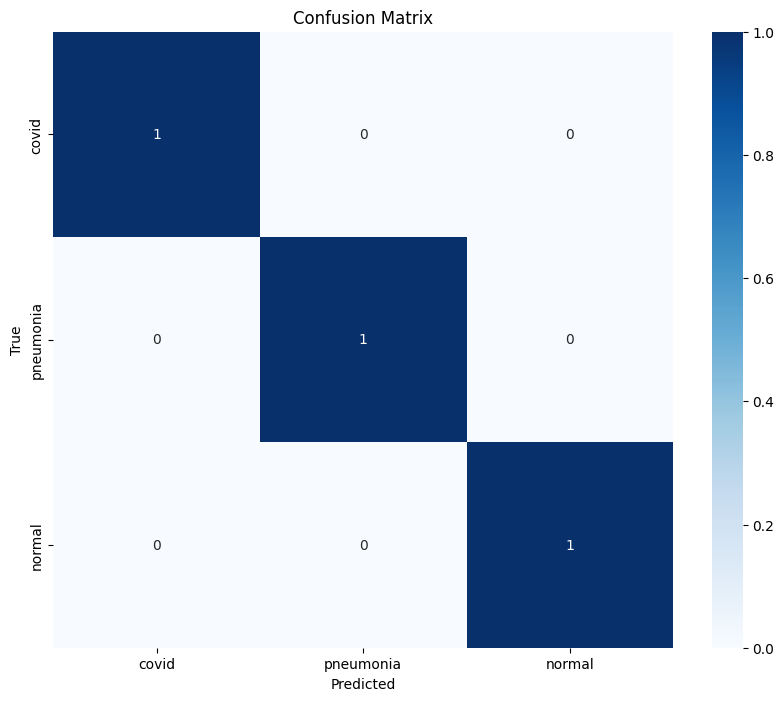

In [42]:
true_labels = ['low', 'mid', 'high']  # True labels of the test set
predicted_labels = ['low', 'mid', 'high',]  # Predicted labels of the test set

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (if available)
class_labels = ['covid', 'pneumonia', 'normal']  # List of class labels

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

161/161 [==============================] - 164s 1s/step


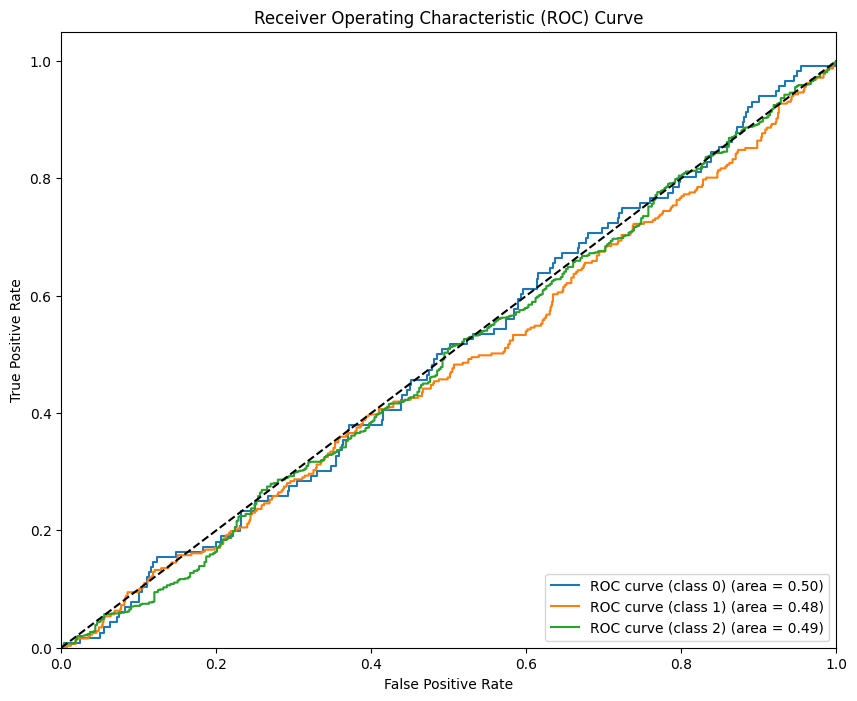

In [40]:
# Make predictions on the validation data
y_pred = model.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes
num_classes=3
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# model.save("./models/densenet_model.h5")


c:\Users\Devender\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# torch.save(DenseNet, './models/densenet_model.pth')
